In [1]:
import pyrox
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import os
from pathlib import Path
from typing import Optional, Iterable
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
client = pyrox.PyroxClient()

STATIONS = [
    "skiErg_time","sledPush_time","sledPull_time","burpeeBroadJump_time",
    "rowErg_time","farmersCarry_time","sandbagLunges_time","wallBalls_time"
]
RUNS = [f"run{i}_time" for i in range(1, 9)]
ALL_SPLITS = STATIONS + RUNS + ["run_time", "total_time"]
def clean_times(df, lower_q=0.0001, upper_q=0.99):
    """
    Cleans unrealistic Hyrox split times.
    - Converts to numeric
    - Removes 0s or > total_time
    - Removes extreme outliers per station/run via quantiles
    """
    df = df.copy()
    df[ALL_SPLITS] = df[ALL_SPLITS].apply(pd.to_numeric, errors="coerce")
    # Drop if any station/run time = 0 or > total_time
    for col in ALL_SPLITS:
        df = df[(df[col] > 0) & (df[col] <= df["total_time"])]

    # Remove per-column outliers using quantiles
    for col in ALL_SPLITS:
        low, high = df[col].quantile(lower_q), df[col].quantile(upper_q)
        print(f"Cleaning {col}...\nHave identified value {low} as low threshold and {high} as high threshold.")
        df = df[(df[col] >= low) & (df[col] <= high)]

    print(f"After cleaning and outlier removal: {len(df)} rows.")
    return df

def filter_top(df, col="total_time", pct=1):
    df = df.copy()
    df[col] = pd.to_numeric(df[col], errors="coerce")
    cutoff = df[col].quantile(pct)
    print(f"cutoff has ben set as: {cutoff}")
    return df[df[col] <= cutoff]
def full_clean(df):
    filtered_df = filter_top(df, col="total_time")
    cleaned_df = clean_times(filtered_df)
    return cleaned_df

In [3]:
s7 = client.get_season(season=7, division='open')
s7 = full_clean(s7)

cutoff has ben set as: 1791.4666666666667
Cleaning skiErg_time...
Have identified value 1.180326666666667 as low threshold and 6.25 as high threshold.
Cleaning sledPush_time...
Have identified value 0.9 as low threshold and 5.583333333333333 as high threshold.
Cleaning sledPull_time...
Have identified value 1.0260783333333334 as low threshold and 10.516666666666667 as high threshold.
Cleaning burpeeBroadJump_time...
Have identified value 0.05 as low threshold and 13.316666666666666 as high threshold.
Cleaning rowErg_time...
Have identified value 2.8552766666666667 as low threshold and 6.633333333333334 as high threshold.
Cleaning farmersCarry_time...
Have identified value 0.5927066666666667 as low threshold and 4.083333333333333 as high threshold.
Cleaning sandbagLunges_time...
Have identified value 0.2633466666666668 as low threshold and 10.516666666666667 as high threshold.
Cleaning wallBalls_time...
Have identified value 0.5728566666666667 as low threshold and 13.766666666666667 as 

In [4]:
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional, Iterable

GENDER_COLORS = {
    "male": "C0",
    "female": "C1",
}

def _safename(s: str) -> str:
    return re.sub(r"[^A-Za-z0-9._-]+", "_", str(s)).strip("_")[:80]

def _to_minutes(x: pd.Series) -> pd.Series:
    x = pd.to_numeric(x, errors="coerce")
    if x.dropna().median() > 300:
        x = x / 60.0
    return x

def _group_stats_array(vals: np.ndarray) -> tuple[float, float, int]:
    vals = vals[np.isfinite(vals) & (vals > 0)]
    if vals.size == 0:
        return np.nan, np.nan, 0
    mu = float(vals.mean())
    sd = float(vals.std(ddof=0))
    return mu, sd, int(vals.size)

def plot_distributions_by_event(
    df: pd.DataFrame,
    outdir: str = "event_distributions",
    min_per_gender: int = 20,
    events: Optional[Iterable[str]] = None,
    bins: int | str = "auto",
    title_suffix: str = "",
) -> pd.DataFrame:
    """
    Create ONE figure per event_name:
      - Left panel: total_time (by gender)
      - Right panel: work_time (by gender)
    Overlaid histograms per gender, with mean (solid) and ±1 SD (dashed) markers.
    Returns a small summary DataFrame with counts used per event/gender.
    """
    req = {"event_name","gender","total_time","work_time"}
    missing = req - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {sorted(missing)}")

    os.makedirs(outdir, exist_ok=True)

    # Clean copy
    data = df.copy()
    data["total_time_min"] = _to_minutes(data["total_time"])
    data["work_time_min"]  = _to_minutes(data["work_time"])

    # Basic filtering
    data = data.dropna(subset=["event_name","gender","total_time_min","work_time_min"])
    if events is not None:
        data = data[data["event_name"].isin(events)]

    # Prepare summary collector
    summary_rows = []

    # Iterate by event
    for ev, g_ev in data.groupby("event_name", sort=False):
        # Counts by gender to decide inclusion
        counts = g_ev["gender"].value_counts()
        keep_genders = counts[counts >= min_per_gender].index.tolist()
        if len(keep_genders) == 0:
            continue

        g_ev = g_ev[g_ev["gender"].isin(keep_genders)]
        if len(g_ev) < 2:
            continue

        # Build shared bins (fairness)
        tt = g_ev["total_time_min"].to_numpy()
        wt = g_ev["work_time_min"].to_numpy()

        tt_bins = bins
        wt_bins = bins
        if isinstance(bins, int):
            tt_bins = np.histogram_bin_edges(tt, bins=bins)
            wt_bins = np.histogram_bin_edges(wt, bins=bins)

        # ---------- Figure ----------
        fig = plt.figure(figsize=(12, 4.8))
        fig.suptitle(f"{ev} {title_suffix}".strip(), fontsize=14)
        # Panel A: total_time
        ax1 = fig.add_subplot(1, 2, 1)
        for gen, g in g_ev.groupby("gender"):
            vals = g["total_time_min"].to_numpy()
            vals = vals[np.isfinite(vals) & (vals > 0)]
            if len(vals) >= min_per_gender:
                ax1.hist(vals, bins=tt_bins, density=False, alpha=0.5, label=f"{gen} (n={len(vals)})", color=GENDER_COLORS[gen])
                mu, sd, _ = _group_stats_array(vals)
                if np.isfinite(mu):
                    # mean solid
                    ax1.axvline(mu, linestyle="-", linewidth=2, label=f"{gen} total_time average", color=GENDER_COLORS[gen])
        ax1.set_xlabel("Finish time (minutes)")
        ax1.set_ylabel("Count")
        ax1.set_title("Total time distribution")
        ax1.legend(loc="best", frameon=False)
        # Panel B: work_time
        ax2 = fig.add_subplot(1, 2, 2)
        for gen, g in g_ev.groupby("gender"):
            vals = g["work_time_min"].to_numpy()
            vals = vals[np.isfinite(vals) & (vals > 0)]
            if len(vals) >= min_per_gender:
                ax2.hist(vals, bins=wt_bins, density=False, alpha=0.5, label=f"{gen} (n={len(vals)})", color=GENDER_COLORS[gen])
                mu, sd, _ = _group_stats_array(vals)
                if np.isfinite(mu):
                    # mean (solid)
                    ax2.axvline(mu, linestyle="-", linewidth=2, label=f"{gen} work_time average", color=GENDER_COLORS[gen])

        ax2.set_xlabel("Work time (minutes)")
        ax2.set_ylabel("Count")
        ax2.set_title("Work time distribution")
        ax2.legend(loc="best", frameon=False)

        fig.tight_layout(rect=[0, 0, 1, 0.95])
        fname = os.path.join(outdir, f"event_{_safename(ev)}.png")
        plt.show()
        fig.savefig(fname, dpi=150)
        # CHANGED: remove plt.show() for batch runs; keep files cleanly written
        # plt.show()
        plt.close(fig)

        # Collect summary
        for gen in keep_genders:
            n_gen = int((g_ev["gender"] == gen).sum())
            summary_rows.append({"event_name": ev, "gender": gen, "n_used": n_gen, "outfile": fname})

    summary = pd.DataFrame(summary_rows).sort_values(["event_name","gender"])
    return summary

### Analysing run times / station times at different events

Below, choosing a mix of events

- Need to keep the analysis fairly small, so we are not building > 70 graphs - but also ensure we are getting enough data and a god variety across regions
- 2024 London - large field, benchmark European course
- 2024 Dalls - North American Event - worth inspecting differences vs Europe?
- 2024 Paris - Another big EU race, but this time outside the UK, which is arguably the Hyrox hub in Europe
- 2025 Berlin - known for being a fast course. Also held in Germany, country where Hyrox first started
- 2025 Shanghai - Aisan Event - same reasoning as choosing Dallas can be applied
- 2025 Johannesburg - Oceania Event - same reasoning as choosing Dallas can be applied

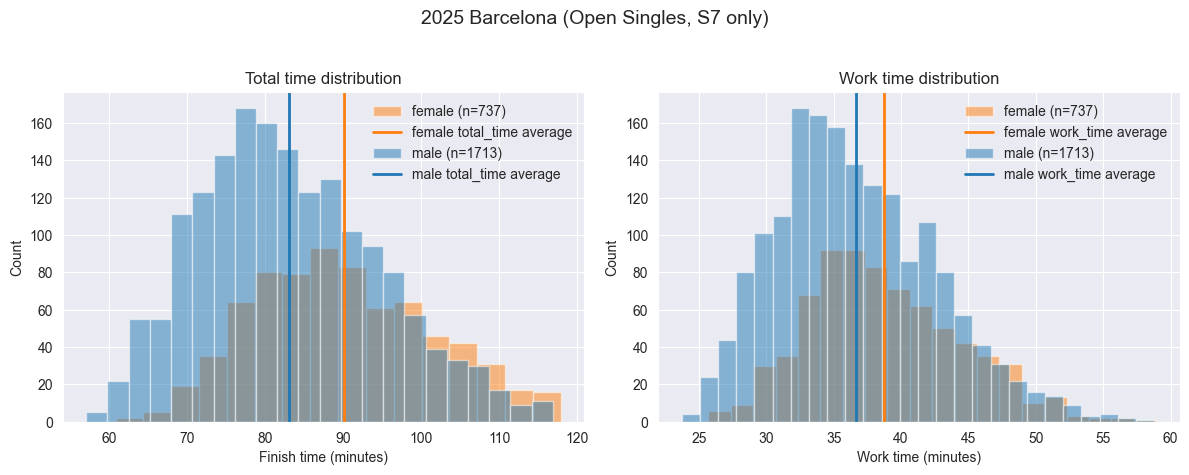

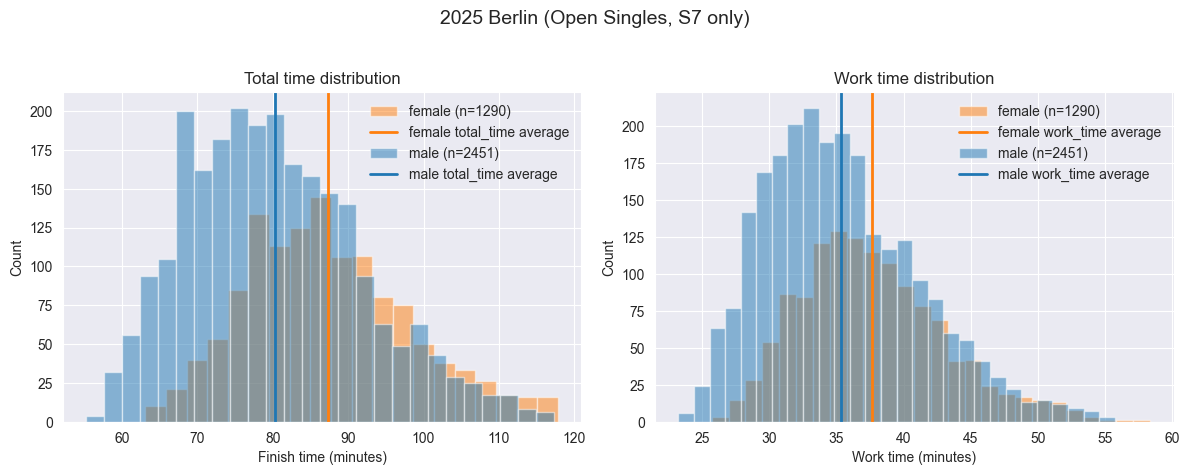

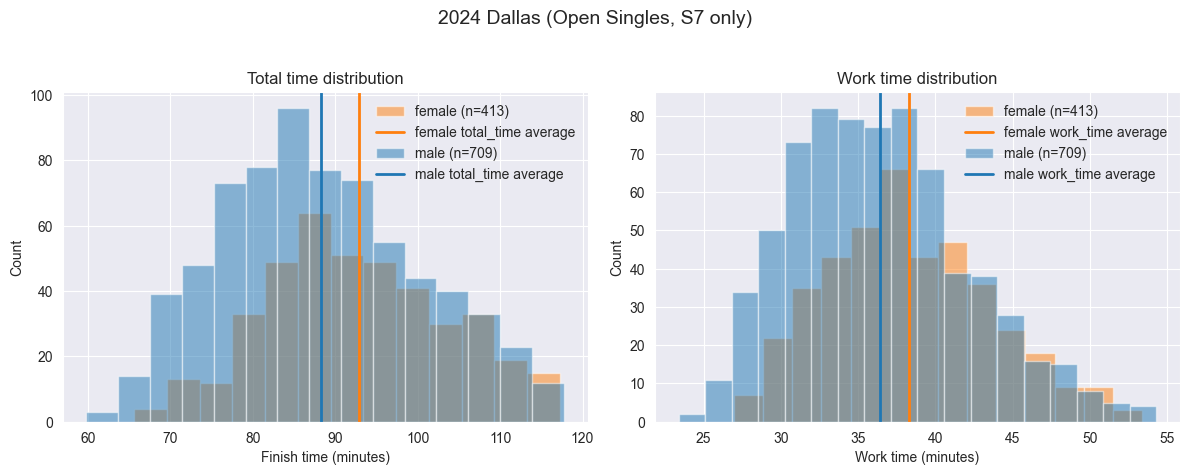

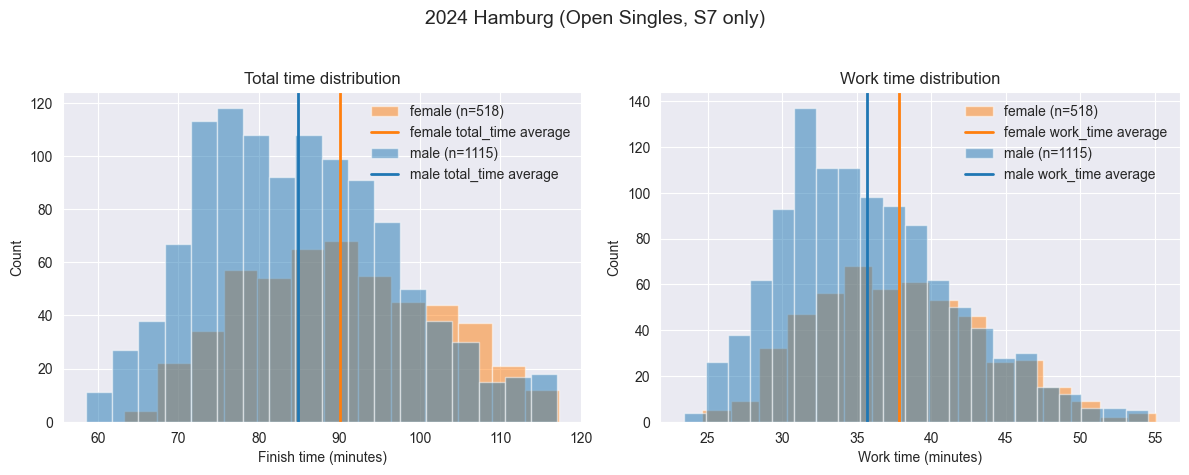

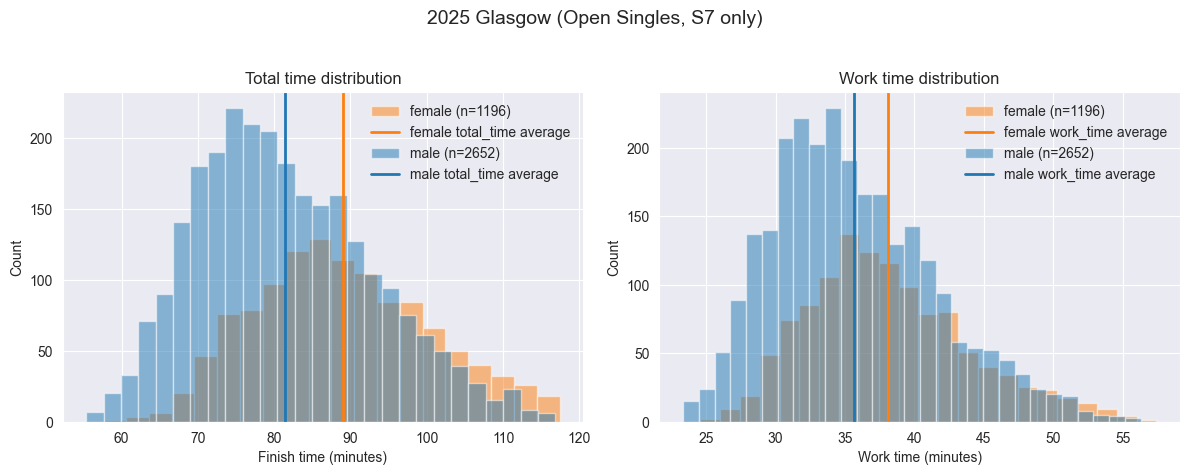

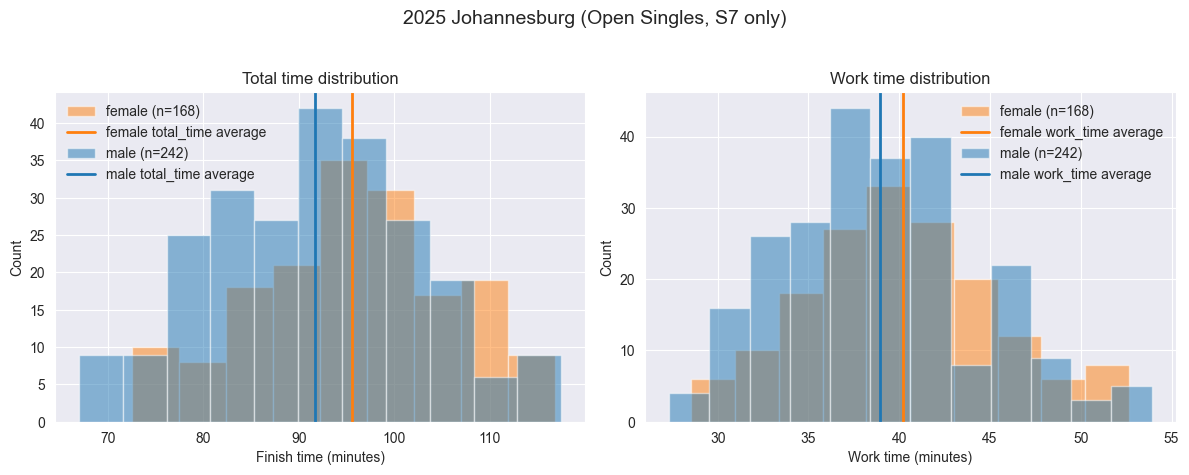

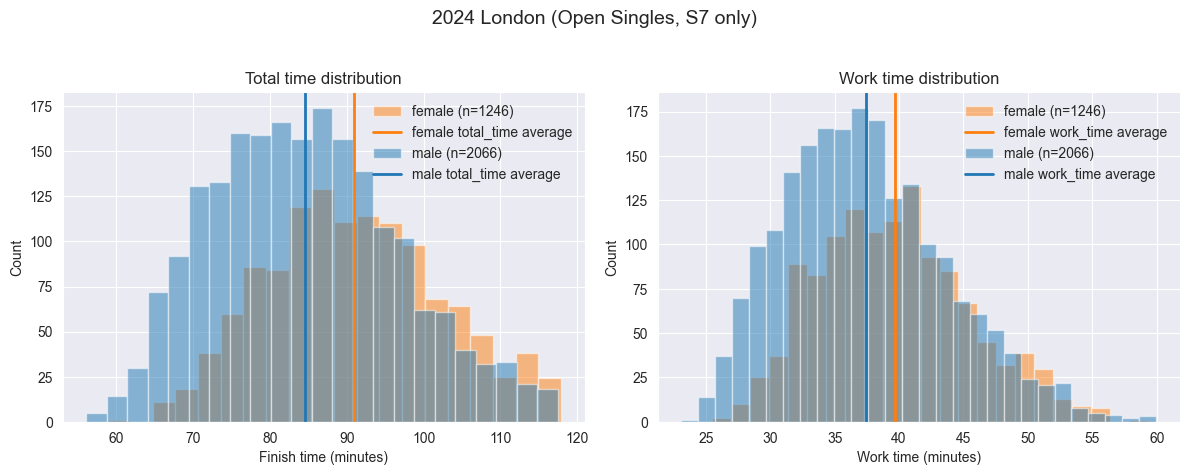

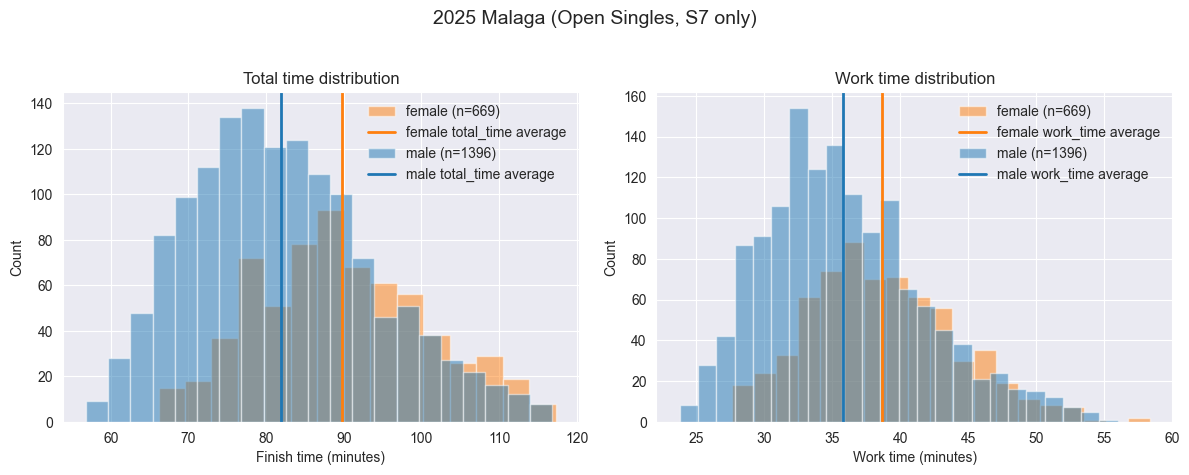

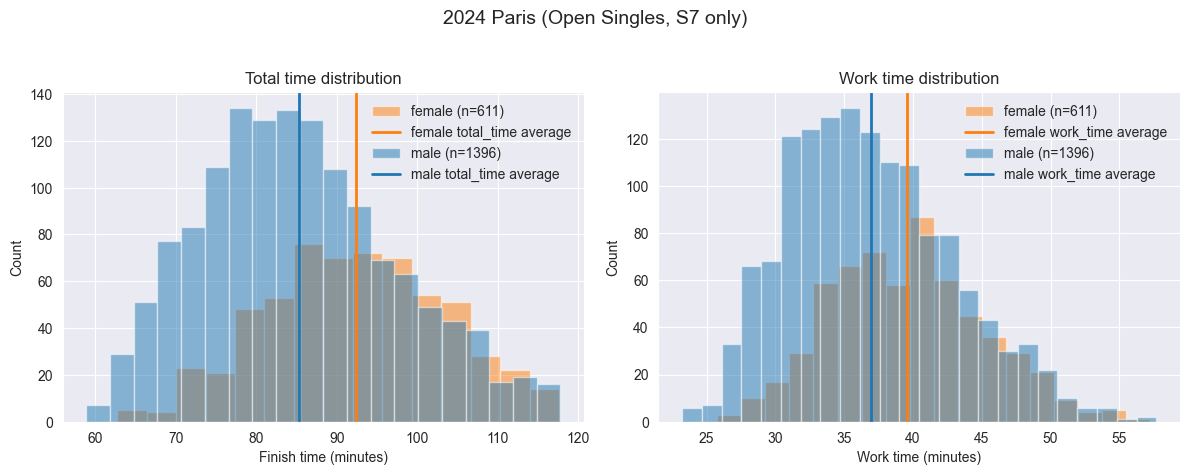

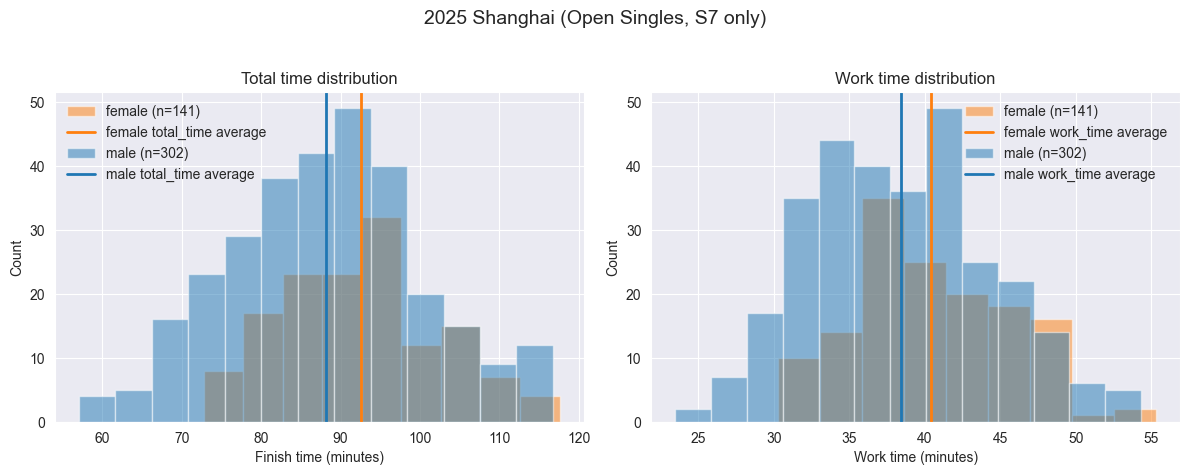

      event_name  gender  n_used                             outfile
5    2024 Dallas  female     413   event_dists/event_2024_Dallas.png
4    2024 Dallas    male     709   event_dists/event_2024_Dallas.png
7   2024 Hamburg  female     518  event_dists/event_2024_Hamburg.png
6   2024 Hamburg    male    1115  event_dists/event_2024_Hamburg.png
13   2024 London  female    1246   event_dists/event_2024_London.png


In [22]:
events_to_analyse = ['2024 London', '2024 Paris', '2024 Dallas', '2025 Berlin', '2025 Shanghai', '2025 Johannesburg', '2025 London', '2025 Glasgow', '2024 Hamburg', '2025 Malaga', '2025 Barcelona']
s7_subset = s7.loc[s7.event_name.isin(events_to_analyse)]
#  Reasons for choosing -- Field Size
summary = plot_distributions_by_event(
    s7_subset,
    outdir="event_dists",
    min_per_gender=20,
    bins="auto",
    title_suffix="(Open Singles, S7 only)"
)
print(summary.head())

### Building a regression model with interaction terms

In this next part, we will build a regression model, trying to estimate the total run time as a function of the event location, station times (approximately choosing sled push, burpees and wall balls) and seeing how the sled push affects the run_time differently at differtn events. 

As a note, the below model presents an "interaction term" -- C(event_name, Treatment(reference='2024 Hamburgh)):sledPush_time
- This allows the slope of the sled push to vary by event. Reasoning behind this is that we expect similar slopes for all events, with small differences (accounting for slightly more competitive athletes potentially in London), except for Berlin, where it is known/believed that the run times were faster due to a smaller run track?



In [23]:

import statsmodels.formula.api as smf
BY = ["gender"]

def prep(df):
    """function to prepare the df for regression analysis"""
    df['remaining_work'] = df['work_time'] - (df['sledPush_time'] + df['burpeeBroadJump_time'])
    df['remaining_time'] = df['total_time'] - (df['sledPush_time'] + df['burpeeBroadJump_time'] + df['run_time'])
    df['event_name'] = df['event_name'].astype("category")
    return df

subset_df = prep(s7_subset.copy())

m = smf.ols("run_time ~ C(event_name, Treatment(reference='2024 Hamburg')) + sledPush_time  + burpeeBroadJump_time + wallBalls_time + C(event_name, Treatment(reference='2024 Hamburg')):sledPush_time", data=subset_df).fit(cov_type='HC3')

levels = subset_df["event_name"].astype("category").cat.categories.tolist()
shown = [p[len("event_name[T."):-1] for p in m.params.index if p.startswith("event_name[T.")]
baseline = next(l for l in levels if l not in shown)
print(baseline)

print(m.summary())

2024 Dallas
                            OLS Regression Results                            
Dep. Variable:               run_time   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     1055.
Date:                Sat, 06 Dec 2025   Prob (F-statistic):               0.00
Time:                        17:12:37   Log-Likelihood:                -59549.
No. Observations:               21031   AIC:                         1.191e+05
Df Residuals:                   21009   BIC:                         1.193e+05
Df Model:                          21                                         
Covariance Type:                  HC3                                         
                                                                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------

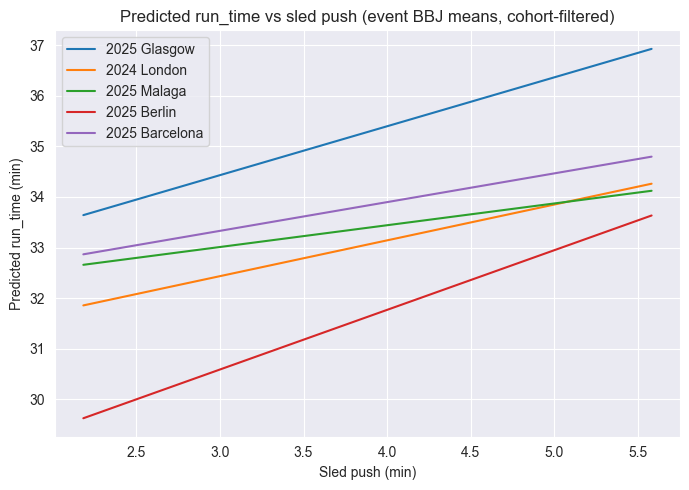

In [26]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

df = subset_df.copy()

#  creare an array of sled push time -- starting from the top 0.1% ro 0.9999% - size of 50
#  to be used below for generating a prediction grid
x = np.linspace(df["sledPush_time"].quantile(0.1),
                df["sledPush_time"].quantile(0.9999), 50)

events = ["2025 Glasgow","2024 London","2025 Malaga", "2025 Berlin", "2025 Barcelona"]  
pred_lines = []

plt.figure(figsize=(7,5))
for ev in events:
    bbj_ev = float(np.nanpercentile(df.loc[df.event_name==ev, "burpeeBroadJump_time"], 0.1))
    wallball_ev = float(np.nanpercentile(df.loc[df.event_name==ev, "wallBalls_time"], 0.11))
    grid = pd.DataFrame({"event_name": ev, "sledPush_time": x, "burpeeBroadJump_time": bbj_ev, "wallBalls_time": wallball_ev})
    y = m.get_prediction(grid).summary_frame()["mean"].to_numpy()
    plt.plot(x, y, label=ev)
plt.xlabel("Sled push (min)"); plt.ylabel("Predicted run_time (min)")
plt.title("Predicted run_time vs sled push (event BBJ means, cohort-filtered)")
plt.legend(); plt.tight_layout(); plt.show()

## Results

Very interesting results - with the slopes backing up our initial theory. 

We are using the mean times per event on burpess, wall balls - which could be pushing up the prediction of run_time in events with fewer athletes, less experiecend ones (i.e Glasgow). However, the slope still clearly shows that Berlin does look like a faster course. 

The same 'top' sled times in London result in a run-time slower by approximately 2 minutes, which does not seem realistic (again, as above, given the calibre of athletes at an usual London event).

However, definitely worth looking into the roxzone times as well! Does the RoxZone account for the difference in performance? Or, is Berlin geniunely a faster course? 

In [27]:
def event_gender_stats_report(df: pd.DataFrame, min_per_gender: int = 20, events: list[str] | None = None) -> pd.DataFrame:
    """Function to return one rwo (per event_name/gender combo" with n, mean, sd, median, iqr for total_time and work_time (in mins)"""
    req = {"event_name","gender","total_time","work_time"}
    miss = req - set(df.columns)
    if miss:
        raise ValueError(f"Missing required columns: {sorted(miss)}")

    d = df.copy()
    if events is not None:
        d = d[d["event_name"].isin(events)]
    rows = []
    for (ev, gen), g in d.groupby(["event_name","gender"], sort=False):
        n = len(g) # number of athletes in that race of that gender
        if n < min_per_gender:
            print(f"Skipping {ev} {gen} due to low n. (n={n})")
            continue
        total_time = g["total_time"]
        work_time = g["work_time"]
        run_time = g["run_time"]
        roxzone_time = g['roxzone_time']

        def stats(s):
            """calculate stats for the given set of numbers (total_time / work_time)"""
            s = pd.to_numeric(s, errors="coerce")
            s = s[np.isfinite(s) & (s>0)]
            if len(s) == 0:
                print(f"for some reason this value seems to be empty. Please check!")
            q1, q3 = np.percentile(s, [25, 75])
            return (float(s.mean()), float(s.std(ddof=0)), float(np.median(s)), float(q3 - q1), int(len(s)))
        total_mean, total_sd, total_med, total_iqr, total_n = stats(total_time)
        work_mean, work_sd, work_med, work_iqr, work_n = stats(work_time)
        run_mean, run_sd, run_med, run_iqr, run_tn = stats(run_time)
        roxzone_mean, roxzone_sd, roxzone_med, roxzone_iqr, rozonez_n = stats(roxzone_time)
        rows.append({
        "event_name": ev, "gender": gen,
        "n_ahtletes": total_n,
        "total_mean": total_mean, "total_sd": total_sd, "total_median": total_med, "total_iqr": total_iqr,
        "work_mean": work_mean, "work_sd": work_sd, "work_median": work_med, "work_iqr": work_iqr,
        "roxzone_mean": roxzone_mean, "roxzone_sd": roxzone_sd, "roxzone_median": roxzone_med, "roxzone_iqr": roxzone_iqr,
        "run_mean": run_mean, "run_sd": run_sd, "run_median": run_med, "run_iqr": run_iqr,
    })
    report = pd.DataFrame(rows).sort_values("gender").reset_index(drop=True)
    return report

report = event_gender_stats_report(subset_df)

/var/folders/1k/w33lpgyn1wj3hkw73yb3nwnc0000gn/T/ipykernel_61161/4272970848.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (ev, gen), g in d.groupby(["event_name","gender"], sort=False):


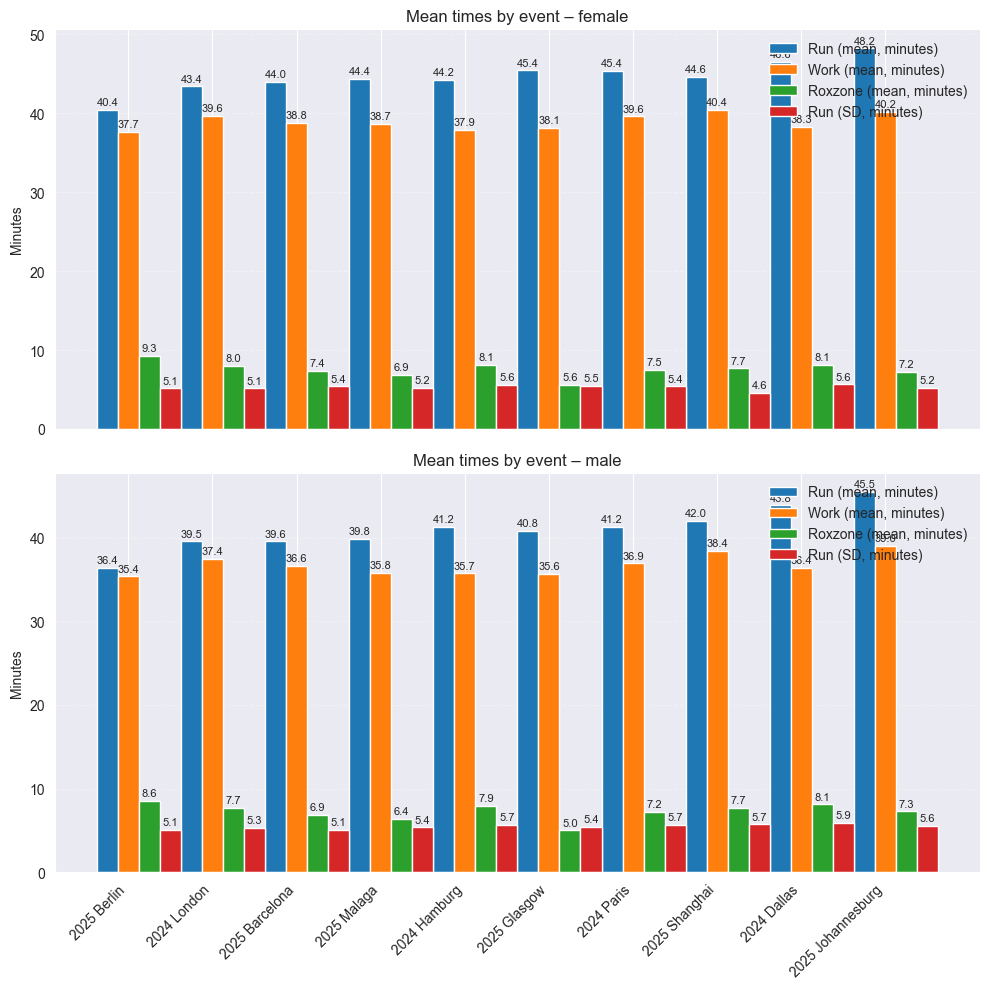

In [30]:
def plot_event_means(report: pd.DataFrame) -> None:
    """
    Visualise run_mean, work_mean, and roxzone_mean by event and gender.

    Parameters
    ----------
    report
        Output of event_gender_stats_report, with at least columns:
        ['event_name', 'gender', 'run_mean', 'work_mean', 'rozone_mean' or 'roxzone_mean'].
    """
    plot_df = report.melt(
        id_vars=["event_name", "gender"],
        value_vars=["run_mean", "work_mean", "roxzone_mean", "run_sd"],
        var_name="metric",
        value_name="minutes",
    )

    event_order = (
        report.groupby("event_name")["run_mean"]
        .mean()
        .sort_values()
        .index.tolist()
    )
    plot_df["event_name"] = pd.Categorical(plot_df["event_name"], categories=event_order, ordered=True)

    genders = sorted(plot_df["gender"].unique())
    n_g = len(genders)

    fig, axes = plt.subplots(
        n_g, 1,
        figsize=(max(8, len(event_order) * 1), 5 * n_g),
        sharex=True,
    )

    if n_g == 1:
        axes = [axes]

    metrics = ["run_mean", "work_mean", "roxzone_mean", "run_sd"]
    metric_labels = {
        "run_mean": "Run (mean, minutes)",
        "work_mean": "Work (mean, minutes)",
        "roxzone_mean": "Roxzone (mean, minutes)",
        "run_sd": "Run (SD, minutes)",
    }

    x = np.arange(len(event_order))
    width = 0.25  # width of each bar

    for ax, gender in zip(axes, genders):
        sub = plot_df[plot_df["gender"] == gender]

        for i, metric in enumerate(metrics):
            msub = sub[sub["metric"] == metric].sort_values("event_name")
            bars = ax.bar(
                x + (i - 1) * width,
                msub["minutes"].values,
                width,
                label=metric_labels[metric],
            )

            ax.bar_label(
                bars,
                fmt="%.1f",
                padding=2,      # distance above bar in points
                fontsize=8,
            )

        ax.set_title(f"Mean times by event – {gender}")
        ax.set_ylabel("Minutes")
        ax.legend(loc='upper right', frameon=False)
        ax.grid(axis="y", linestyle="--", alpha=0.3)

    axes[-1].set_xticks(x)
    axes[-1].set_xticklabels(event_order, rotation=45, ha="right")

    fig.tight_layout()
    plt.show()

plot_event_means(report)

Above is fairly simple plot - but shows again what we have been looking at. Berlin (first race) has a slower average run-time -- it does have a longer (the longest roxzone), but the difference in roxzone times does not seem to account for the exact difference we are seeing in run times. The red bar represents the standard deviation in run times -- interesting that it seems to be fairly stable regardless of event, which would show that the distribution of athlete levels performing at different events is very similar.